Guillaume Dechambre. CID: 02257544 (this report is the result of my independent work)

### Libraries

In [166]:
############################### general ###############################
# file helper
import os
# numerical library
import numpy as np
# as requested
np.random.seed(30224)
# dataframe library
import pandas as pd
# dates handling
from datetime import datetime as dt
# for object serialization
import pickle
# for deepcopy of nested lists
import copy


############################### analytics ###############################
# to get the term matrix
from sklearn.feature_extraction.text import CountVectorizer
# as a better (filtering out common words) alternative: tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
# LDA library
import gensim
from gensim import models
# load saved LDA model from Gensim
from gensim import  models
# for LSA model from Gensim
from gensim.models import LsiModel
# to build a dictionary of words
import gensim.corpora as corpora
# to save LDA model to disk
from gensim.test.utils import datapath


############################### visualization ###############################
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# LDAvis 
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
# print LDA model more compactly
from pprint import pprint
# plot correlation matrix
import seaborn as sns
# TSNE dimensionality reduction and visualization
from sklearn.manifold import TSNE

############################### data cleaning ###############################
# regular expressions
import re
## get nltk toolbox, e.g. to remove english stop words
import nltk
from nltk.corpus import stopwords
# uncomment this to download nltk dictionaries
# to install nltk, go to https://www.nltk.org/
#nltk.download()
# to set the path of the downloaded dictionary
from nltk.data import path as nltk_path
nltk_path.append( '../nltk_data')
# downloading stopwords for english
nltk.download('stopwords')
print(stopwords.words('english'))
# differentiating the different word tags
from nltk.tag import pos_tag
# for stemming
from nltk.stem.porter import PorterStemmer

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Global Variables

In [155]:
############################### global variables ###############################
# if false, will load existing model from disk
_run_lda_model_ = False
# if true, will replace the current LDA model saved
_save_lda_model_ = False
# if false, will re-run boe minutes pre-processing
# otherwise, will load from serialized folder below
_load_saved_boe_data_ = True
# if true, will save down figures to disk in image folder
_save_figures_ = True
# if true, uncertainty will be based on the sum of tf-idf
_uncertainty_from_tfidf_ = True

############################### folders ###############################
image_dir = "./images/"
serialized_dir = 'serialized_data/'
ldavis_dir = 'ldavis/'

does_exist = os.path.exists(image_dir)
if not does_exist:
   # Create "images" directory because it does not exist
   os.makedirs(image_dir)
   print("images directory created!")

does_exist = os.path.exists(serialized_dir)
if not does_exist:
   # Create "serialization" directory because it does not exist
   os.makedirs(serialized_dir)
   print("serialization directory created!")

does_exist = os.path.exists(ldavis_dir)
if not does_exist:
   # Create "ldavis" directory because it does not exist
   os.makedirs(ldavis_dir)
   print("ldavis directory created!")

### Pre-Processing

In [67]:
############################### documents parsing ###############################
# flattening a list of list
def flatten(xss):
    return [x for xs in xss for x in xs]

def preprocessing(docs_full_text, doc_name, drop_na=True, min_doc_char_count = 100):
    '''
    Preprocessing of the data: identifies and split BOE paragraphs, removes stop words and words without
    too much semantic attached (e.g. prepositions) and performs stemming, computes document weight
    '''
    # docs_tok_filtered_aslist: tokens list per document (list of lists)
    # all_words: all words as one big list (not unique)
    # docs_weight: list of couple (minutes date, doc weight)
    # Remove white space at the beginning and end
    cleaning_full_text = docs_full_text.strip()  
    # Replace the \r with null
    cleaning_full_text = cleaning_full_text.replace('\r', '') 
    while '  ' in cleaning_full_text:
        # Remove extra spaces
        cleaning_full_text = cleaning_full_text.replace('  ', ' ') 
        # Remove content within HTML tags
        cleaning_full_text = re.sub(r'(<[^>]*>)|' 
                        '([_]+)|' # Remove series of underscores
                        '(http[^\s]+)|' # Remove website addresses
                        '((a|p)\.m\.)', # Remove "a.m" and "p.m."
                        '', cleaning_full_text) # Replace with null
    # removes page numbers from BOE raw files
    cleaning_full_text = re.sub('\n *\d+ *\n', '\n', cleaning_full_text, flags=re.DOTALL)
    # to lower case
    cleaning_full_text  = str.lower(cleaning_full_text)
    # removes first paragraph
    cleaning_full_text = re.sub('(.*)(?=before turning)', '', cleaning_full_text, flags=re.DOTALL)
    # split paragraphs which start number, can (?) have a number, a ")" and some text
    # in the middle with lookahead assertion for various ending; 
    # the last paragraph is ignored.
    cleaning_full_text = re.findall('\n\d+[:)\.]? (.+?)(?=\.?\n\n\d|\.?\n\n|\.?\n\d+ )',
                                    cleaning_full_text, flags=re.DOTALL)
    # convert to series
    docs_cleaning = pd.Series(cleaning_full_text)
    # removing fractions
    docs_cleaning = docs_cleaning.str.replace("[0-9]*\/[0-9]*","")
    # removing group of numbers
    docs_cleaning = docs_cleaning.str.replace("[0-9]+","")
    # remove characters/numbers at beginning
    docs_cleaning = docs_cleaning.str.replace("[^A-Za-z0-9]", " ")
    # remove multi-spaces for one space
    docs_cleaning = docs_cleaning.str.replace("\s+"," ")
    # Removing Stopwords from English Dictionary 
    stop_words = set(stopwords.words('english'))
    # remove recipes that are NA
    if drop_na:
        docs_cleaning = docs_cleaning[~docs_cleaning.isna()]
    docs_cleaning.reset_index(drop=True, inplace=True)
    # Tokenization
    docs_tok = docs_cleaning.apply(lambda x: x.split())
    # see nltk for the meaning of all these acronyms 
    # (essentially keep nouns, adverbs, verbs and adjectives)
    fun_exclude = lambda tag: (tag[1] not in ['MD','CD','CC','DT','EX','IN','LS','MD','NNP',
                                            'PDT','POS','PRP','PRP$','TO','UH',
                                            'WDT','WP','WRB', 'RP']) and (tag[0] not in stop_words)
    # Stemming    
    stemmer = PorterStemmer()
    docs_tok = docs_tok.apply(lambda doc_line: [stemmer.stem(tag[0]) for tag in pos_tag(doc_line) if fun_exclude(tag)])
    # filter docs that do not meet min length
    docs_tok_filtered = docs_tok[docs_tok.apply(lambda x: len("".join(x)) > min_doc_char_count).values]
    # compute document weights in sub-corpus (for a given meeting date)
    # minutes_weight is unused at this point
    minutes_weight = 1/(docs_tok_filtered.apply(lambda x: len("".join(x))).sum())
    corpusdate_total_weight = docs_tok_filtered.apply(lambda x: 1/len("".join(x))).sum()
    docs_weight = [[doc_name,weight] for weight in docs_tok_filtered.apply(lambda x: 1/len("".join(x))/corpusdate_total_weight).to_list()]
    # rejoin the sentence
    docs_cleaning = docs_tok_filtered.apply(lambda x: " ".join(x))
    # returns full documents and tokenized version
    docs_tok_filtered_aslist = docs_tok_filtered.to_list()
    all_words = flatten(docs_tok_filtered.to_list())
    return docs_tok_filtered_aslist, all_words, docs_weight, minutes_weight

<>:17: DeprecationWarning: invalid escape sequence \s
<>:18: DeprecationWarning: invalid escape sequence \.
<>:26: DeprecationWarning: invalid escape sequence \d
<>:30: DeprecationWarning: invalid escape sequence \d
<>:34: DeprecationWarning: invalid escape sequence \/
<>:40: DeprecationWarning: invalid escape sequence \s
<>:17: DeprecationWarning: invalid escape sequence \s
<>:18: DeprecationWarning: invalid escape sequence \.
<>:26: DeprecationWarning: invalid escape sequence \d
<>:30: DeprecationWarning: invalid escape sequence \d
<>:34: DeprecationWarning: invalid escape sequence \/
<>:40: DeprecationWarning: invalid escape sequence \s
C:\Users\guill\AppData\Local\Temp\ipykernel_38416\1834463807.py:17: DeprecationWarning: invalid escape sequence \s
  '(http[^\s]+)|' # Remove website addresses
C:\Users\guill\AppData\Local\Temp\ipykernel_38416\1834463807.py:18: DeprecationWarning: invalid escape sequence \.
  '((a|p)\.m\.)', # Remove "a.m" and "p.m."
C:\Users\guill\AppData\Local\Temp

In [7]:
############################### dates parsing ###############################
# all minutes dates sorted from old to new
boe_dates = pd.read_csv("boe_meeting_dates.txt").\
    apply(lambda x: dt.strptime(x["date"], "%d-%b-%y"),axis=1)
dates_dt = np.flip([a_date.date() for a_date in boe_dates])
dates_str = np.flip([a_date.date().strftime("%Y-%m-%d") for\
                      a_date in boe_dates])#.strftime("%d-%m-%Y")
dates_indices = np.argsort(dates_dt)
# date in various format
dates_str       = dates_str[dates_indices]
dates_dt        = dates_dt[dates_indices]
dates_dt64      = list(map(lambda x: np.datetime64(x),dates_dt))
date_str_dt     = dict(zip(dates_str, dates_dt))
date_str_dt64   = dict(zip(dates_str, dates_dt64))

In [156]:
############################### data file serialization ###############################

# serialize a parsed data file
def save_data_serialized(obj_to_save, name_of_file):
    fileObj = open('serialized_data/'+name_of_file+'.obj', 'wb')
    pickle.dump(obj_to_save,fileObj)
    fileObj.close()

# load a parsed data file
def load_serialized_data(obj_names):
    objects = []
    for obj_name in obj_names:
        fileObj = open('serialized_data/'+obj_name+'.obj', 'rb')
        objects.append(pickle.load(fileObj))
        fileObj.close()
    return objects

# load and split each 'minutes'
def process_large_file(file_name):
    infile = open(os.getcwd()+"\\"+file_name, 'r')
    all_minutes_txt = infile.read()
    infile.close()
    without_headers = re.sub(r'\n\d+-\d+-\d+_boe_minutes\n', '', all_minutes_txt)
    minutes_split = re.split("\*"*50, without_headers)[1:]
    return minutes_split

# either load from serialized folder or
# proceed to data parsing (~10 minutes)
if not _load_saved_boe_data_:
    minutes_split = process_large_file("boe_all_minutes.txt")
    # minutes_weights could be used for future work
    minutes_weights = []
    # see pre-processing function
    docs_tokens_list, all_words, docs_weight, inst_minutes_weights = \
        preprocessing(minutes_split[0],dates_str[0])
    # minutes_weights could be used for future work
    minutes_weights.append(inst_minutes_weights)
    # processing minutes meeting date by meeting date
    for date_index in range(1,len(dates_str)):
        print(f"processing minutes from {dates_str[date_index]}")
        outputs = preprocessing(minutes_split[date_index],dates_str[date_index])
        docs_tokens_list = docs_tokens_list + outputs[0]
        all_words = all_words + outputs[1]
        docs_weight = docs_weight + outputs[2]
        # minutes_weights could be used for future work
        minutes_weights.append(outputs[3])

    # save serialized data
    save_data_serialized(docs_tokens_list,"docs_tok_filtered_aslist")
    save_data_serialized(all_words,"all_words")
    save_data_serialized(docs_weight,"docs_weight")
    save_data_serialized(minutes_weights,"minutes_weights")
else:
    # or load serialized data instead
    saved_data_list = load_serialized_data(["docs_tok_filtered_aslist",
                                            "all_words","docs_weight",
                                            "minutes_weights"])
    docs_tokens_list            = saved_data_list[0]
    all_words                   = saved_data_list[1]
    docs_weight                 = saved_data_list[2]
    minutes_weights             = saved_data_list[2]

############################### loading uncertainty lexicon ###############################
def load_file(file_name):
    print(f"processing file {file_name}")
    infile = open(file_name, 'r')
    data = infile.read()
    infile.close()
    return data
uncertainty_words = load_file("uncertainty_words_finlex_plus_lm.txt").split("\n")

processing file uncertainty_words_finlex_plus_lm.txt


<>:24: DeprecationWarning: invalid escape sequence \*
<>:24: DeprecationWarning: invalid escape sequence \*
C:\Users\guill\AppData\Local\Temp\ipykernel_38416\1023548724.py:24: DeprecationWarning: invalid escape sequence \*
  minutes_split = re.split("\*"*50, without_headers)[1:]


C:\Users\guill\AppData\Local\Temp\ipykernel_38416\412903844.py:42: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_rotation(30)
C:\Users\guill\AppData\Local\Temp\ipykernel_38416\412903844.py:42: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_rotation(30)
C:\Users\guill\AppData\Local\Temp\ipykernel_38416\412903844.py:42: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_rotation(30)
C:\Users\guill\AppData\Local\Temp\ipykernel_38416\412903844.py:42: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_rotation(30)
C:\Users\guill\AppData\Local\Temp\ipykernel_38416\412903844.py:42: Matpl

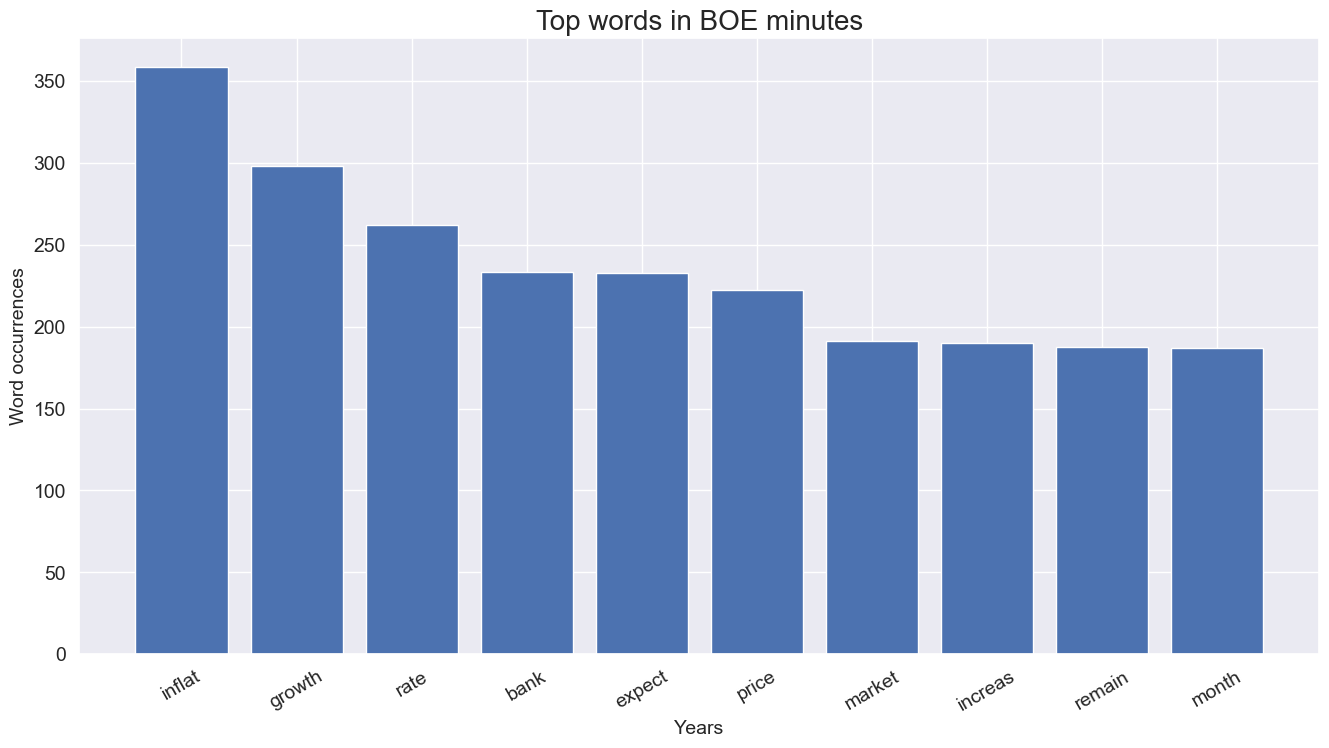

In [153]:
############################### preliminary view ###############################

def top_words(n_words, count_vectorizer, documents):
    '''
    returns top n words and their frequencies
    '''
    docs_list_string = np.array([" ".join(doc_word_list) for\
                                doc_word_list in documents], dtype=object)
    #document_tfidf_matrix = used_vectorizer.fit_transform(docs_list_string)
    # this computes the term frequency stored matrix in sparse matrix form
    term_freq_mat = count_vectorizer.fit_transform(docs_list_string)
    # get the sum of frequency number by word across documents
    count_per_word = np.sum(term_freq_mat, axis=0)
    # get most frequent words and indices
    word_freq_indices = np.argsort(-count_per_word)
    word_freq = -np.sort(-count_per_word)
    word_vectors = np.zeros((n_words, term_freq_mat.shape[1]))
    for i in range(n_words):
        word_vectors[i,word_freq_indices[0,i]] = 1
    # get back the words
    words = [word[0] for 
             word in count_vectorizer.inverse_transform(word_vectors)]
    return (words, word_freq[0,:n_words].tolist()[0])

# Top words based on TF-IDF
words, word_values = top_words(
        n_words=10,
        count_vectorizer=TfidfVectorizer(stop_words='english'), 
        documents=docs_tokens_list)

# we plot the top 10 words and their frequencies
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in BOE ''minutes''', fontsize=20);
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(14) 
                tick.label.set_rotation(30)
for tick in ax.yaxis.get_major_ticks():
                tick.label1.set_fontsize(14) 
ax.set_xlabel('Years', fontsize=14);
ax.set_ylabel('Word occurrences', fontsize=14);
plt.show()


fig.savefig(\
    image_dir+"top_words.png",\
        bbox_inches='tight')


### Building Model

In [159]:
############################### BOW and TF-IDF ###############################
# form dictionary by mapping word IDs to words
id2word = corpora.Dictionary(docs_tokens_list)
# apply Bag of Words to all documents in corpus
corpus = [id2word.doc2bow(doc) for doc in docs_tokens_list] 
# fit TF-IDF model
tfidf = models.TfidfModel(corpus) 
# apply TF-IDF model
corpus_tfidf = tfidf[corpus]
# how many document in the corpus
len(corpus_tfidf)

6367

In [158]:
############################### building uncertainty score ###############################
# copying the dictionary without altering it
id2word_with_uncertainty = copy.deepcopy(id2word)
# adding the uncertainty word list to our dictionary
id2word_with_uncertainty.add_documents([uncertainty_words])
# retrieve index for each word
uncertainty_indices = [bow[0] for bow in id2word_with_uncertainty.doc2bow(uncertainty_words)]
uncertainty_score = np.zeros(len(corpus))
# either build using tf-idf or from BOW directly
if _uncertainty_from_tfidf_:
    for i in range(len(corpus)):
        uncertainty_score[i] = np.sum([tfidf[1] for\
                                        tfidf in corpus_tfidf[i] if tfidf[0] in uncertainty_indices])
else:
    for i in range(len(corpus)):
        uncertainty_score[i] = np.sum([bow[1] for\
                                        bow in corpus[i] if bow[0] in uncertainty_indices])

In [13]:
############################### function to train LDA ###############################
def run_lda(corpus, id2word, num_topics = 6, 
            passes = 50, alpha = 0.125, 
            eta = 0.125, 
            general_seed = 30224, 
            lda_seed = 400):
    '''
    Train the LDA model for a certain (either tf-idf or BOW) "corpus", dictionary "id2word",
    number of topics "num_topics", number of passes "passes", with hyper-parameters
    "alpha", "eta", numpy seed "general_seed", LDA seed "lda_seed".
    Returns: a trained LDA model, coherence score and print coherence as well
    as log perplesity.
    '''
    np.random.seed(general_seed)
    eta_array_best = np.array([eta]*len(list(id2word.token2id))) # Set eta
    Lda = gensim.models.ldamodel.LdaModel
    lda_model = Lda(corpus, num_topics = num_topics, \
                id2word = id2word, passes= passes, 
                random_state=lda_seed,
                alpha=alpha,eta=eta)
    cm = gensim.models.coherencemodel.CoherenceModel(\
            model=lda_model, texts=docs_tokens_list,\
            dictionary=id2word, coherence='c_v')
    coherence_score = cm.get_coherence()
    # print coherence score and perplexity
    print('-'*50)
    print('\nCoherence Score:', coherence_score)
    print('-'*50)
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
    return (lda_model,coherence_score)


In [22]:
############################### best parameters for chosen LDA ###############################
lda_seed = 400
num_topics_best = 6
alpha_best = 0.15
eta_best = 0.32
# the default LDA model takes an array of eta prior tokens
eta_array_best = np.array([eta_best]*len(list(id2word.token2id)))
num_passes_best = 700

In [19]:
############################### run chosen LDA on dataset ###############################

# if one does not use the trained model
# this will take ~20 minutes
if _run_lda_model_:
    lda_model, coherence = run_lda(corpus_tfidf, id2word,
                                num_topics=num_topics_best,
                                passes=num_passes_best,
                                alpha=alpha_best,
                                eta=eta_best,
                                lda_seed=lda_seed)
    # print the top 15 weighted words per topic
    pprint(lda_model.print_topics(num_words=15))
else:
    lda_model = models.ldamodel.LdaModel.load(os.getcwd()+"\\"+"lda_model_used")
    pprint(lda_model.print_topics(num_words=15))

    cm = gensim.models.coherencemodel.CoherenceModel(\
                model=lda_model, texts=docs_tokens_list,\
                dictionary=id2word, coherence='c_v')
    coherence = cm.get_coherence()
    # print coherence score and perplexity
    print('-'*50)
    print('\nCoherence Score:', coherence)
    print('-'*50)
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# save the model to disc with name "new" to not delete
# previous model accidentally
if _save_lda_model_:
    lda_file = datapath(os.getcwd()+"\\"+"lda_model_new")
    lda_model.save(lda_file)

[(0,
  '0.000*"administrations." + 0.000*"journey" + 0.000*"pre-omicron" + '
  '0.000*"relaxations," + 0.000*"removals," + 0.000*"reservations," + '
  '0.000*"high-contact" + 0.000*"flight" + 0.000*"devolv" + 0.000*"train" + '
  '0.000*"restaur" + 0.000*"track" + 0.000*"card" + 0.000*"week" + '
  '0.000*"high-frequ"'),
 (1,
  '0.006*"rate" + 0.006*"yield" + 0.005*"bond" + 0.005*"unit" + 0.005*"market" '
  '+ 0.005*"equiti" + 0.005*"basi" + 0.004*"interest" + 0.004*"govern" + '
  '0.004*"sterl" + 0.004*"previou" + 0.004*"meeting," + 0.004*"euro" + '
  '0.003*"mpc’" + 0.003*"uk"'),
 (2,
  '0.000*"fco" + 0.000*"carers," + 0.000*"professionals," + 0.000*"volunt" + '
  '0.000*"effort" + 0.000*"citizen" + 0.000*"combat" + 0.000*"front" + '
  '0.000*"country," + 0.000*"extraordinari" + 0.000*"nh" + 0.000*"compris" + '
  '0.000*"health" + 0.000*"abroad" + 0.000*"covid-19"'),
 (3,
  '0.011*"inflat" + 0.006*"cpi" + 0.006*"price" + 0.004*"target" + '
  '0.004*"expect" + 0.004*"polici" + 0.004*"pa

In [27]:
############################### visualize the topic with LDAvis ###############################
pyLDAvis.enable_notebook()
# we will save the HTML file here
LDAvis_data_filepath = os.path.join('./ldavis/ldavis_tuned_'+str(num_topics_best))
# run LDAvis (a few seconds)
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
# save the view as HTML file
pyLDAvis.save_html(LDAvis_prepared, './ldavis/ldavis_tuned_'+ str(num_topics_best) +'.html')
# display in Notebook
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.123282  0.063728       1        1  45.353481
3     -0.144680 -0.050246       2        1  39.922902
1     -0.021568 -0.026401       3        1  10.513854
4      0.116450 -0.036795       4        1   3.695571
2      0.086562  0.024865       5        1   0.257967
0      0.086517  0.024850       6        1   0.256225, topic_info=         Term         Freq        Total Category  logprob  loglift
240   purchas   428.000000   428.000000  Default  30.0000  30.0000
194    inflat  1741.000000  1741.000000  Default  29.0000  29.0000
4        bank   930.000000   930.000000  Default  28.0000  28.0000
509       cpi   983.000000   983.000000  Default  27.0000  27.0000
1484    stock   256.000000   256.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
426     year.     0.098687   264.493733   Topic6  -9.1633  -1.9268
457   previou     0.098631   622.324130   Topic6  -9.1639  -2.7830
239    measur     0.098629   705.864609   Topic6  -9.1639  -2.9089
912    econom     0.098626   587.812712   Topic6  -9.1639  -2.7260
275     first     0.098623   451.434972   Topic6  -9.1640  -2.4620

[403 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7850      1  0.085349  (andrew
7850      2  0.085349  (andrew
7850      3  0.056899  (andrew
7850      4  0.796592  (andrew
5467      1  0.358689    (apf)
...     ...       ...      ...
112       4  0.003649    yield
3186      1  0.140162     £100
3186      2  0.112129     £100
3186      3  0.056065     £100
3186      4  0.728840     £100

[1288 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 2, 5, 3, 1])

In [249]:
############################### train LSA model ###############################
num_lsa_topics = 6
lsa = LsiModel(corpus=corpus_tfidf, 
               num_topics=num_lsa_topics, 
               id2word = id2word, random_seed=lda_seed)
# print the top 15 words per LSA "topic"
pprint(lsa.print_topics(num_topics=num_lsa_topics, num_words=15))

[(0,
  '0.208*"inflat" + 0.142*"growth" + 0.130*"rate" + 0.130*"expect" + '
  '0.128*"price" + 0.112*"bank" + 0.102*"remain" + 0.101*"increas" + '
  '0.099*"cpi" + 0.097*"polici" + 0.096*"market" + 0.096*"committe" + '
  '0.092*"gdp" + 0.087*"like" + 0.086*"unit"'),
 (1,
  '0.394*"vote" + 0.250*"maintain" + 0.238*"proposit" + 0.220*"bank" + '
  '0.212*"favour" + 0.208*"purchas" + 0.204*"stock" + 0.179*"unanim" + '
  '0.172*"asset" + 0.163*"issuanc" + 0.155*"committe" + 0.155*"financ" + '
  '0.153*"regard" + 0.142*"proposition." + 0.140*"invit"'),
 (2,
  '0.357*"inflat" + 0.216*"cpi" + 0.187*"target" + -0.182*"gdp" + '
  '-0.168*"growth" + -0.126*"output" + 0.126*"price" + -0.119*"survey" + '
  '-0.118*"invest" + -0.116*"quarter" + -0.112*"estim" + -0.111*"busi" + '
  '0.107*"polici" + -0.107*"indic" + 0.103*"medium"'),
 (3,
  '-0.220*"bond" + 0.199*"inflat" + -0.194*"yield" + 0.180*"pay" + 0.172*"cpi" '
  '+ 0.158*"vote" + -0.151*"govern" + -0.149*"interest" + -0.147*"equiti" + '
  '-0

### Topic Proportions Through Time

In [161]:
############################### weighting topics ###############################
# start doc counter
doc_counter = 0 
# we copy document inverse weight
docs_subcorpus_topic_weight = copy.deepcopy(docs_weight)
# for each paragraph, we get the document-topic probability
# and multiply the weight by the document weight within 'minutes' sub-corpus
for para in docs_weight:
    TFIDF_para = tfidf[corpus[doc_counter]]
    # generate and store weighted topic proportions for each paragraph
    for topic_weight in lda_model.get_document_topics(TFIDF_para):
        # weights are the second element of the list, topic proportions are the second element of each doc-weight tuple 
        docs_subcorpus_topic_weight[doc_counter].\
            append(docs_weight[doc_counter][1]*topic_weight[1]) 
    doc_counter += 1

# naming the main topics manually from top words
main_topics = ['General News 1', 'Financial Markets', 'General News 2', 'Inflation', 
               'Policy Decision', 'Growth']

# form dataframe of weighted topic proportions (documents) - include topic names
boe_topics_x_time = pd.DataFrame(docs_subcorpus_topic_weight, columns=['Date_str', 'Weight']+main_topics)
boe_topics_x_time['Date_dt64'] = boe_topics_x_time.apply(lambda x:date_str_dt64[x['Date_str']],axis=1)
# adding uncertainty score
boe_topics_x_time['Uncertainty Score'] = uncertainty_score
# aggregate topic mix by 'minutes' documents (weighted sum of paragraphs)
topics_time_agg_df = pd.pivot_table(boe_topics_x_time, 
                                    values=main_topics+['Uncertainty Score'], 
                                    index='Date_dt64', aggfunc=np.sum)


C:\Users\guill\AppData\Local\Temp\ipykernel_38416\89897431.py:27: FutureWarning: The provided callable <function sum at 0x0000019566678940> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  topics_time_agg_df = pd.pivot_table(boe_topics_x_time,


In [162]:
############################### smooth out topic proportions ###############################
def interp_and_smooth(topics_agg_df, freq_interp="M", rolling_window = 6):
    '''
    Take the freq_interp frequency and apply a rolling (6 months) window average
    of the topic proportions
    '''
    oidx = topics_agg_df.index
    nidx = pd.date_range(topics_agg_df.index.min(),
                        topics_agg_df.index.max(), freq = freq_interp)
    # we have to reindex the table on the union of frequencies first
    # then interpolate on the monthly time points
    topics_agg_df_reind = topics_agg_df.reindex(oidx.union(nidx)).\
        interpolate('index').reindex(nidx)
    # fill the NAs with moving average
    topics_agg_smooth_df = topics_agg_df_reind.rolling(rolling_window, center=True).mean()
    return topics_agg_smooth_df

# apply the above
topics_time_agg_smooth_df = interp_and_smooth(topics_time_agg_df)

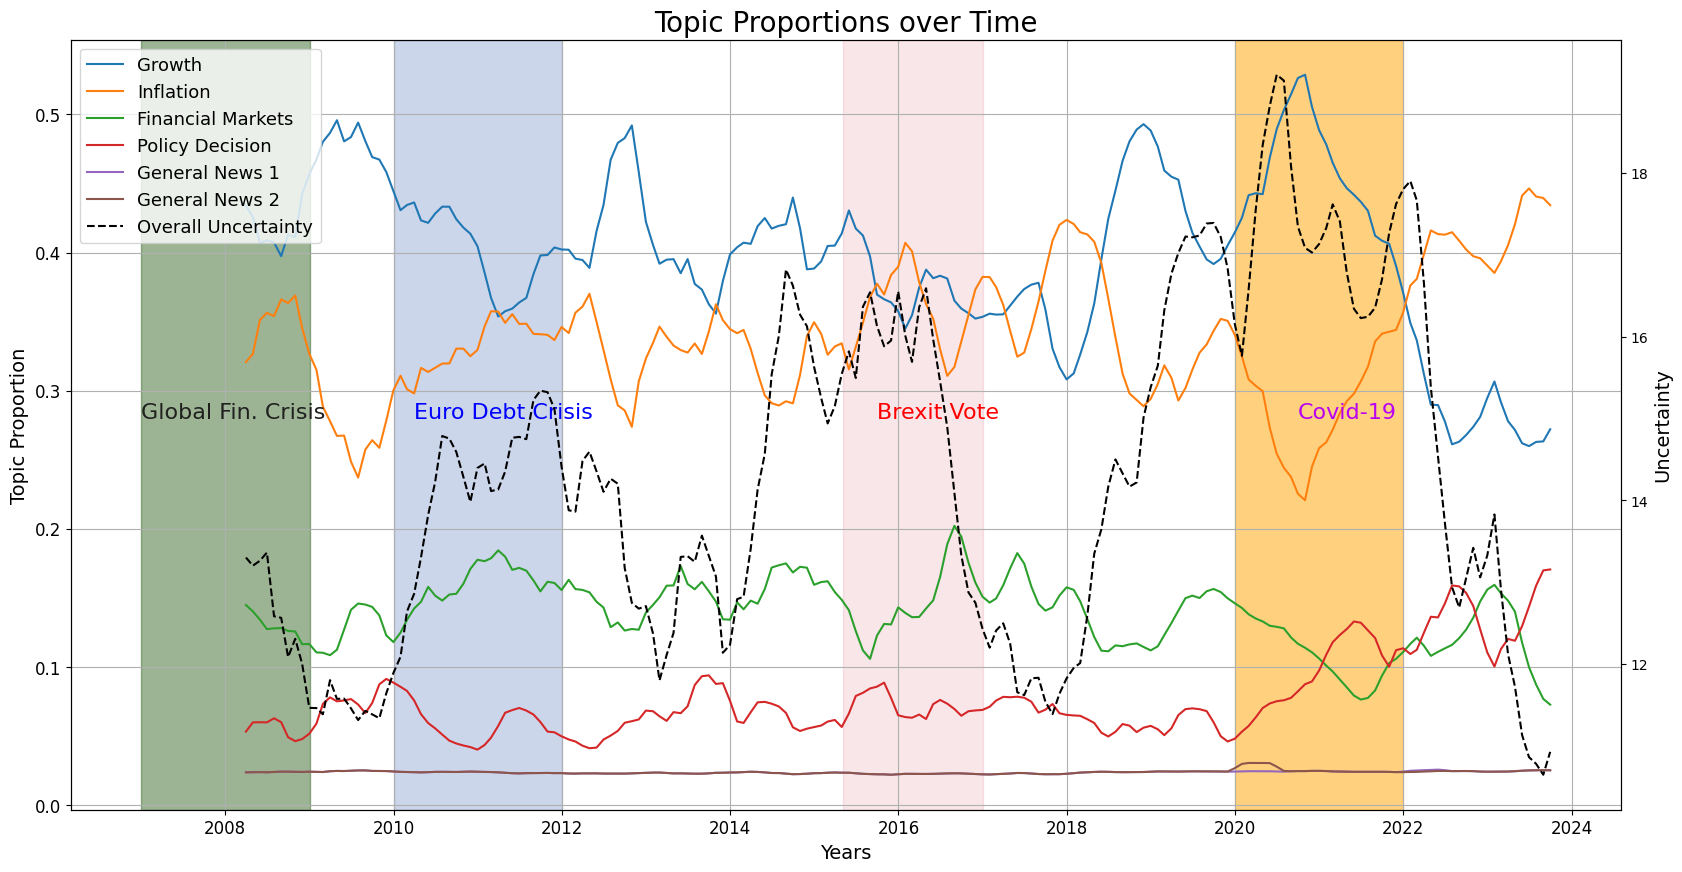

In [117]:
############################### display topic proportions through time ###############################

# reorder manually the topic from most relevant to least
display_topic_order = [4,2,5,1,3,0]
relevant_topics = np.array(main_topics)[np.argsort(display_topic_order)]
# prepare plot
fig, ax = plt.subplots(figsize=(20,10)) 
ax.grid()
# plot each topic
lns1 = ax.plot(topics_time_agg_smooth_df[relevant_topics[0]], label=relevant_topics[0])
for topic in relevant_topics[1:]:
    lns1 += ax.plot(topics_time_agg_smooth_df[topic], label=topic)
# add a second axis for uncertainty
ax2 = ax.twinx()
# merge the axis for the legends
lns1 += ax2.plot(topics_time_agg_smooth_df['Uncertainty Score'], '--', color = 'black', label='Overall Uncertainty') 
labs = [l.get_label() for l in lns1]
ax.legend(lns1, labs, loc='upper left', fontsize=13)
# add interesting events
ax.axvspan(np.datetime64(dt(2007,1,1)), np.datetime64(dt(2009,1,1)), alpha=0.5, color='#3A6B2B')
ax.axvspan(np.datetime64(dt(2010,1,1)), np.datetime64(dt(2012,1,1)), alpha=0.2, color='#003399')
ax.axvspan(np.datetime64(dt(2015,5,7)), np.datetime64(dt(2017,1,1)), alpha=0.1, color='#C8102E')
ax.axvspan(np.datetime64(dt(2020,1,1)), np.datetime64(dt(2022,1,1)), alpha=0.5, color='orange')
ax.set_xlabel('Years', fontsize=14);
ax.set_ylabel('Topic Proportion', fontsize=14);
for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
                tick.label1.set_fontsize(12) 
ax2.set_ylabel('Uncertainty', fontsize=14);
# name interesting events
ax.annotate('Global Fin. Crisis',
            xy=(np.datetime64(dt(2007,1,1)), 0.28), xycoords='data',color='#20211F', fontsize=16)
ax.annotate('Euro Debt Crisis',
            xy=(np.datetime64(dt(2010,4,1)), 0.28), xycoords='data',color='blue', fontsize=16)
ax.annotate('Brexit Vote',
            xy=(np.datetime64(dt(2015,10,1)), 0.28), xycoords='data',color='red', fontsize=16)
ax.annotate('Covid-19',
            xy=(np.datetime64(dt(2020,10,1)), 0.28), xycoords='data',color='#BA00F2', fontsize=16)
plt.title('Topic Proportions over Time', fontsize=20)

# save or not
if _save_figures_:
    fig.savefig(\
        image_dir+"topics_over_time.png",\
            bbox_inches='tight')

### Clustering, Topic Proportions Correlation and Word Cloud

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 9548 samples in 0.011s...
[t-SNE] Computed neighbors for 9548 samples in 0.418s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9548
[t-SNE] Computed conditional probabilities for sample 2000 / 9548
[t-SNE] Computed conditional probabilities for sample 3000 / 9548
[t-SNE] Computed conditional probabilities for sample 4000 / 9548
[t-SNE] Computed conditional probabilities for sample 5000 / 9548
[t-SNE] Computed conditional probabilities for sample 6000 / 9548
[t-SNE] Computed conditional probabilities for sample 7000 / 9548
[t-SNE] Computed conditional probabilities for sample 8000 / 9548
[t-SNE] Computed conditional probabilities for sample 9000 / 9548
[t-SNE] Computed conditional probabilities for sample 9548 / 9548
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.167213
[t-SNE] KL divergence after 2000 iterations: 0.558484


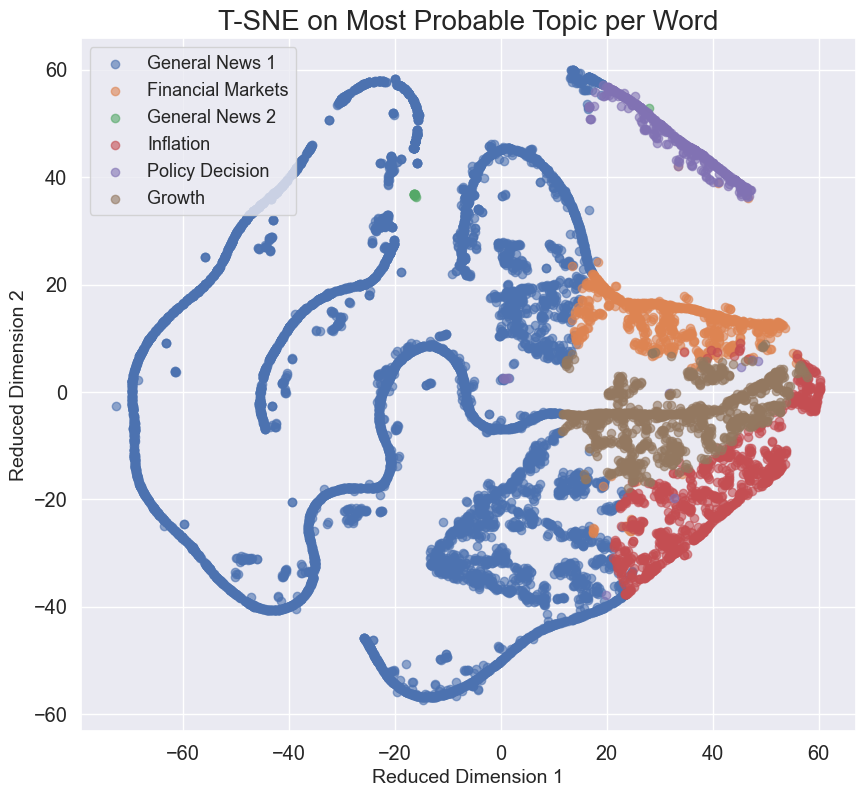

In [167]:
############################### TSNE visual ###############################

# find all unique words
n_words = np.shape(lda_model.get_topics())[1]
# assign a "best topic" per word finding the highest probability for coloring
best_topic_perword = [np.where(lda_model.get_topics()[:,i] ==\
                                np.max(lda_model.get_topics()[:,i]))[0][0] for i in range(0,n_words)]
# chooses standard T-SNE parameters and represent the 6 dimesional data in 2-d
tsne_term_topic_model = TSNE(n_components=2, perplexity=60, learning_rate=50, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_terms_topics = tsne_term_topic_model.fit_transform(lda_model.get_topics().T)
# plot TSNE using plt
fig, ax = plt.subplots(figsize=(10,9)) 
for i in range(len(main_topics)):
    plt.scatter(tsne_terms_topics[np.array(best_topic_perword)==i, 0], tsne_terms_topics[np.array(best_topic_perword)==i, 1], alpha=0.6, label=main_topics[i])
ax.set_xlabel('Reduced Dimension 1', fontsize=14);
ax.set_ylabel('Reduced Dimension 2', fontsize=14);
plt.legend(loc='upper left', fontsize=13)
plt.title('T-SNE on Most Probable Topic per Word', fontsize=20)
plt.show()
# save or not
if _save_figures_:
    fig.savefig(\
        image_dir+"words_topic_tsne.png",\
            bbox_inches='tight')


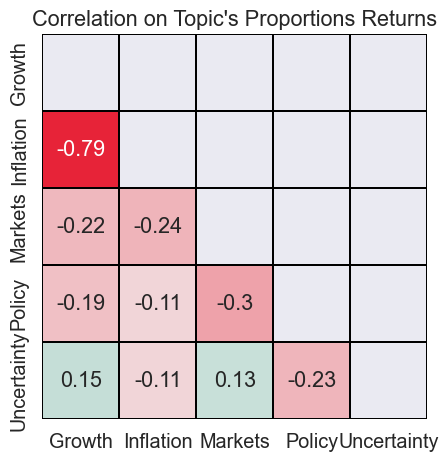

In [169]:
############################### topics absolute return correlation ###############################
# compute absolute returns (log-returns are not necessary for proportions, which could be theoretically zero at times)
topics_absolute_returns = topics_time_agg_smooth_df.shift(1)-topics_time_agg_smooth_df
# remove irrelevant topics
topics_absolute_returns.drop("General News 1",axis=1, inplace=True)
topics_absolute_returns.drop("General News 2",axis=1, inplace=True)
# rename topics for space
topics_absolute_returns.rename(columns={"Financial Markets": "Markets",
                                         "Policy Decision": "Policy",
                                           "Uncertainty Score": "Uncertainty"}, inplace=True)
corr_matrix = topics_absolute_returns[['Growth','Inflation', 'Markets',
                                        'Policy','Uncertainty']].corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))
sns.set(font_scale=1.3)

# generate a custom diverging colormap
cmap = sns.diverging_palette(10, 160, s=90, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
heatmap_corr = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.1, cbar = False ,
            cbar_kws={"shrink": .5}, linecolor='black', annot=True).\
                set_title('Correlation on Topic\'s Proportions Returns')
fig = heatmap_corr.get_figure()
# save or not
if _save_figures_:
    fig.savefig(\
        image_dir+"topics_correlation.png",\
            bbox_inches='tight')

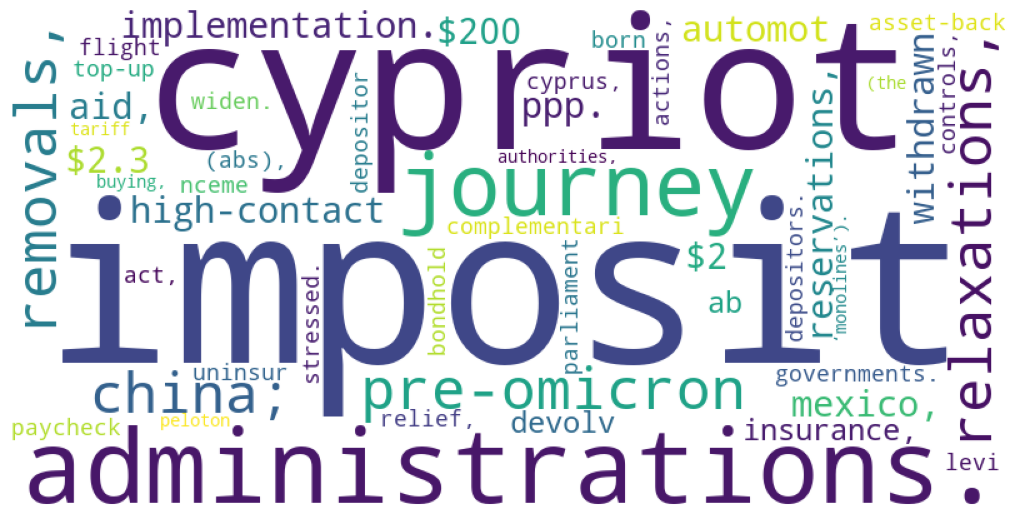

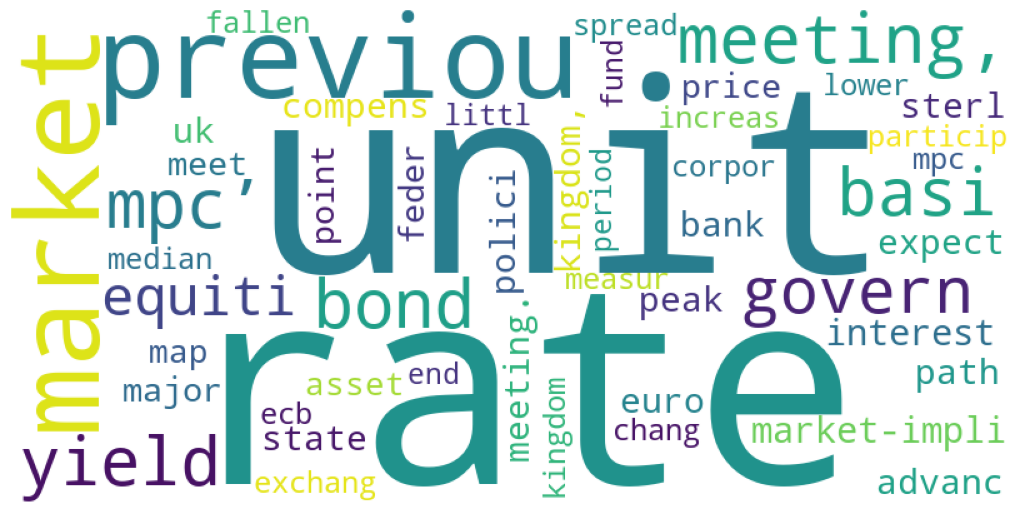

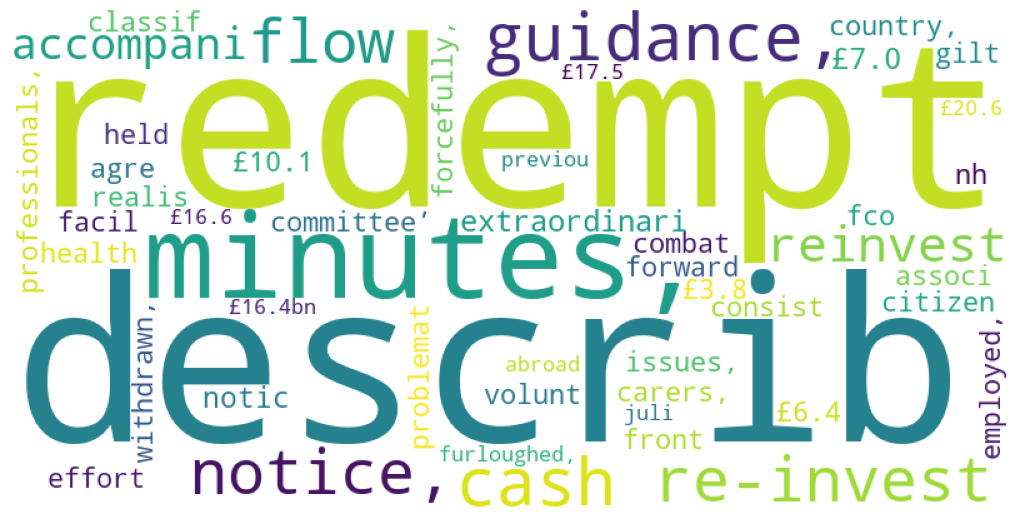

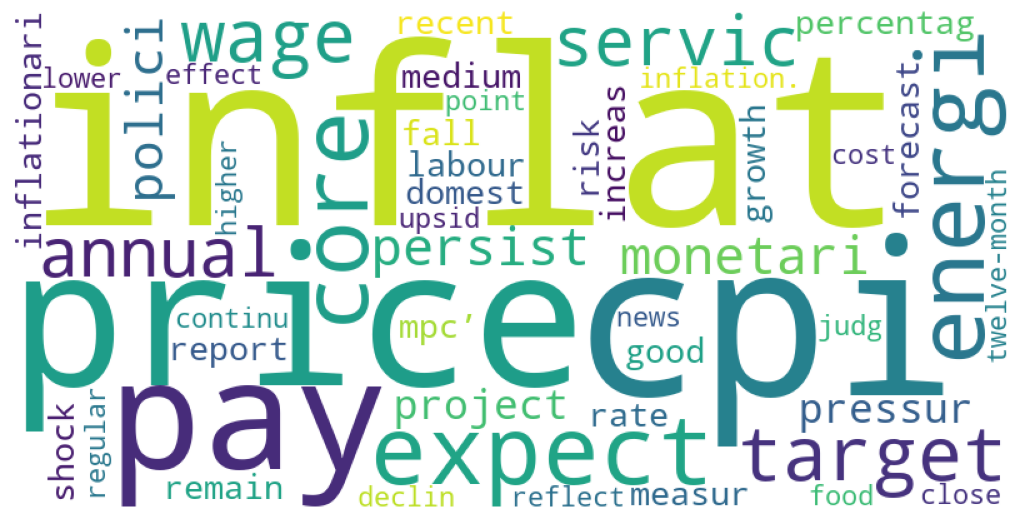

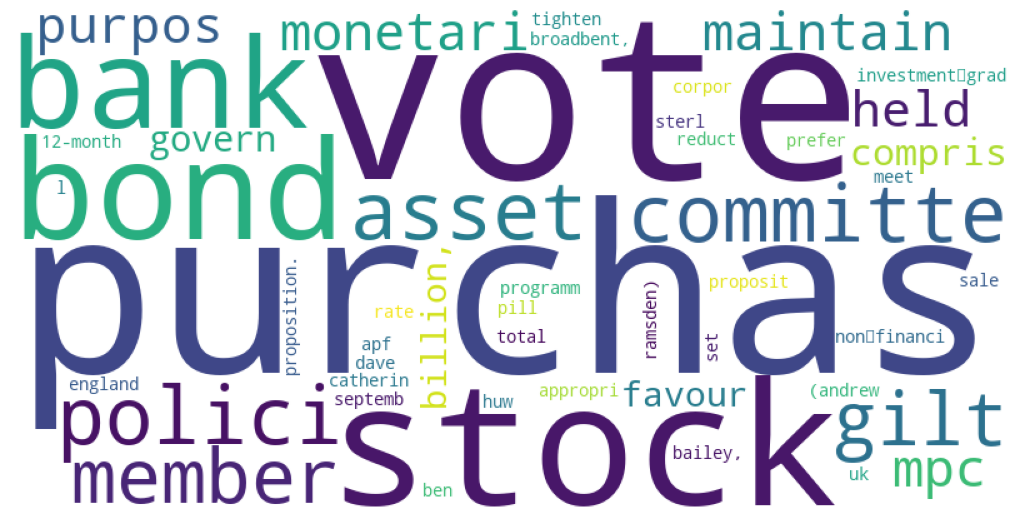

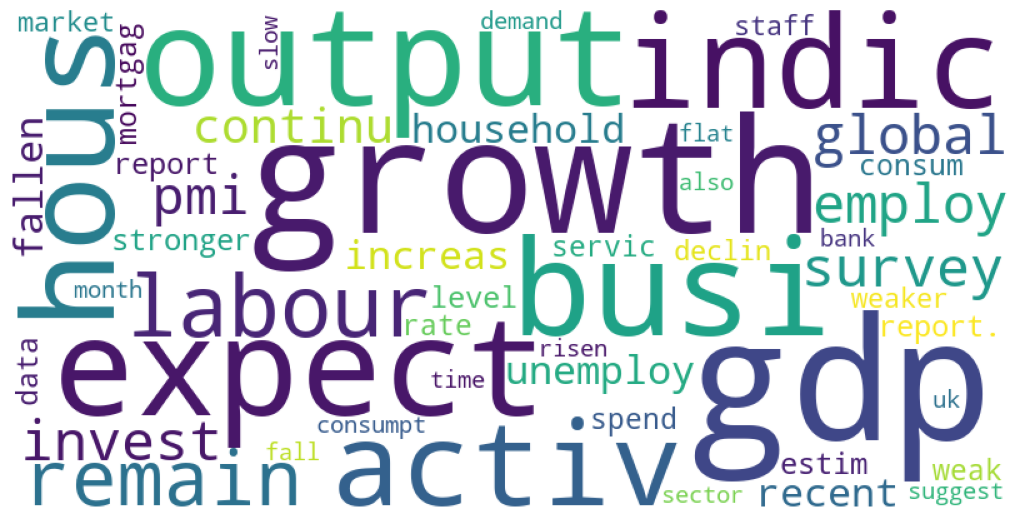

In [76]:
############################### word cloud of most frequent words ###############################
topic = 0
while topic < num_topics_best:
    # topics and frequencies and store in a dictionary structure
    # key-value pairs - this is needed as input for the 'generate_from_frequencies' word cloud function
    topic_words_freq = dict(lda_model.show_topic(topic, topn=50)) 
    topic += 1
    # Generate Word Cloud for topic using frequencies
    wordcloud = WordCloud(background_color="white",width=800, 
                          height=400, random_state=7).generate_from_frequencies(topic_words_freq) 
    # plot all word clouds
    fig, ax = plt.subplots(figsize=(10,10)) 
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    # save or not
    if _save_figures_:
        fig.savefig(\
            image_dir+"topic_"+str(topic)+"_wordcloud.png",\
                bbox_inches='tight')


### Parameters Tuning

--------------------------------------------------

Coherence Score: 0.5768904735500023
--------------------------------------------------

Perplexity:  -8.691080153767011
--------------------------------------------------

Coherence Score: 0.6736898926233974
--------------------------------------------------

Perplexity:  -8.660186075098304
--------------------------------------------------

Coherence Score: 0.6759894829304837
--------------------------------------------------

Perplexity:  -8.648392841064904
--------------------------------------------------

Coherence Score: 0.6705787067334196
--------------------------------------------------

Perplexity:  -8.640444449084715
--------------------------------------------------

Coherence Score: 0.669912977277567
--------------------------------------------------

Perplexity:  -8.635705718631728
--------------------------------------------------

Coherence Score: 0.6712196905551705
--------------------------------------------------

P

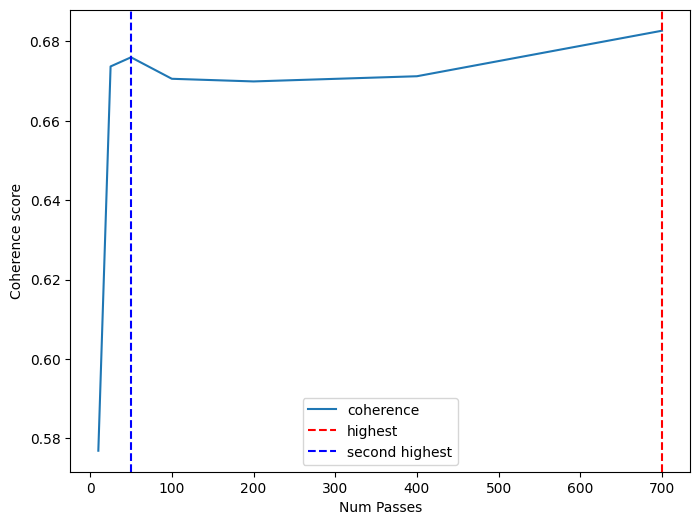

In [138]:
############################### tune number of passes ###############################
# each parameter tuning block takes about 20 minutes to run

# use optimal paramter
lda_seed_num_passes = 400
num_topics_num_passes = 6
alpha_num_passes = 0.15
eta_num_passes = 0.32

# plot graph of coherence values by varying num passes
num_passes_range = [10,25,50,100,200,400,700]
coherence_values_num_passes = []
model_list_num_passes = []
for num_passes in num_passes_range:
    lda_model, coherence = run_lda(corpus_tfidf, id2word,
                            num_topics=num_topics_num_passes,
                            passes=num_passes,
                            alpha=alpha_num_passes,
                            eta=eta_num_passes,
                            lda_seed=lda_seed_num_passes)
    model_list_num_passes.append(lda_model)
    coherence_values_num_passes.append(coherence)

# plotting
fig, ax = plt.subplots(figsize=(8,6))
num_passes_best = num_passes_range
plt.plot(num_passes_best, coherence_values_num_passes, label = "coherence")
plt.xlabel("Num Passes", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
num_pass_best = num_passes_best[np.where(coherence_values_num_passes==np.max(coherence_values_num_passes))[0][0]]
num_pass_second_best = num_passes_best[np.argsort(coherence_values_num_passes)[-2]]
plt.title('Tuning Number of Passes', fontsize=16);
plt.axvline(num_pass_best, color='r', linestyle="--", label = "highest");
plt.axvline(num_pass_second_best, color='b', linestyle="--", label = "second highest");
plt.legend(loc='best', fontsize=14)
plt.show()

# save or not
if _save_figures_:
    fig.savefig(\
        image_dir+"num_passes.png",\
            bbox_inches='tight')

--------------------------------------------------

Coherence Score: 0.4920693144045525
--------------------------------------------------

Perplexity:  -8.56057350712419
--------------------------------------------------

Coherence Score: 0.46747675678059475
--------------------------------------------------

Perplexity:  -8.667145411393498
--------------------------------------------------

Coherence Score: 0.6244424901326313
--------------------------------------------------

Perplexity:  -8.750727743206124
--------------------------------------------------

Coherence Score: 0.6535592473498906
--------------------------------------------------

Perplexity:  -8.81460980245485
--------------------------------------------------

Coherence Score: 0.5572826887529184
--------------------------------------------------

Perplexity:  -8.93127682688611
--------------------------------------------------

Coherence Score: 0.6121954586236839
--------------------------------------------------

Pe

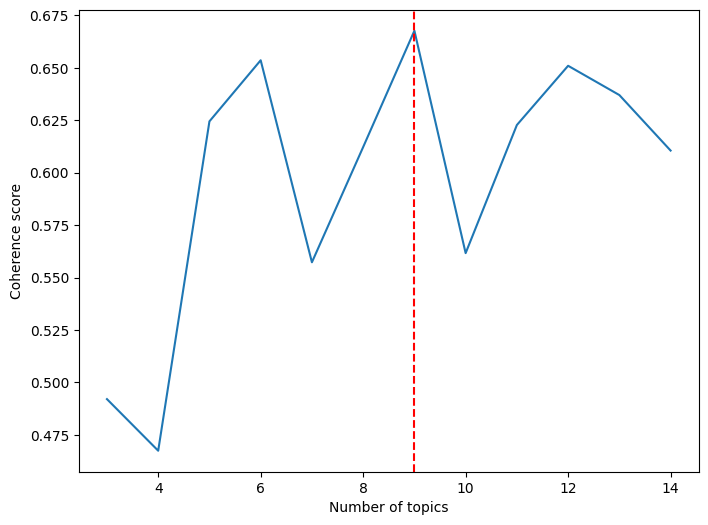

In [205]:
############################### tune number of topics ###############################
# each parameter tuning block takes about 20 minutes to run

# use good paramter
base_alpha = 0.15
base_eta = 0.32
# reduced number of passes
base_num_passes = 50
base_lda_seed = 400
# number of topics range
limit=15; start=3; step=1;
numTopics_range = list(np.arange(start,limit, step))
coherence_values_topics = []
model_list_topics = []
for num_topics in numTopics_range:
    lda_model, coherence = run_lda(corpus_tfidf, id2word,
                            num_topics=num_topics,
                            passes=base_num_passes,
                            alpha=base_alpha,
                            eta=base_eta,
                            lda_seed=base_lda_seed)
    model_list_topics.append(lda_model)
    coherence_values_topics.append(coherence)
# plotting
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(numTopics_range, coherence_values_topics, label = "coherence")
plt.xlabel("Number of topics", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
#plt.legend(("coherence"), loc='best')
numTopics_best = numTopics_range[np.where(coherence_values_topics==np.max(coherence_values_topics))[0][0]]
numTopics_second_best = numTopics_range[np.argsort(coherence_values_topics)[-2]]
plt.title('Tuning Number of Topics', fontsize=16);
plt.axvline(numTopics_best, color='r', linestyle="--", label = "highest");
plt.axvline(numTopics_second_best, color='b', linestyle="--", label = "second highest");
plt.legend(loc='best', fontsize=14)
plt.show()
# save or not
if _save_figures_:
    fig.savefig(\
        image_dir+"numtopics_calibration.png",\
            bbox_inches='tight')

--------------------------------------------------

Coherence Score: 0.5846559439789473
--------------------------------------------------

Perplexity:  -9.745261024277704
--------------------------------------------------

Coherence Score: 0.6371637090926016
--------------------------------------------------

Perplexity:  -8.982209838196637
--------------------------------------------------

Coherence Score: 0.5288134525794662
--------------------------------------------------

Perplexity:  -8.77154032415796
--------------------------------------------------

Coherence Score: 0.3632753160599469
--------------------------------------------------

Perplexity:  -8.736242787472213
--------------------------------------------------

Coherence Score: 0.29541762623289985
--------------------------------------------------

Perplexity:  -8.723586481722736
--------------------------------------------------

Coherence Score: 0.2862899333209182
--------------------------------------------------



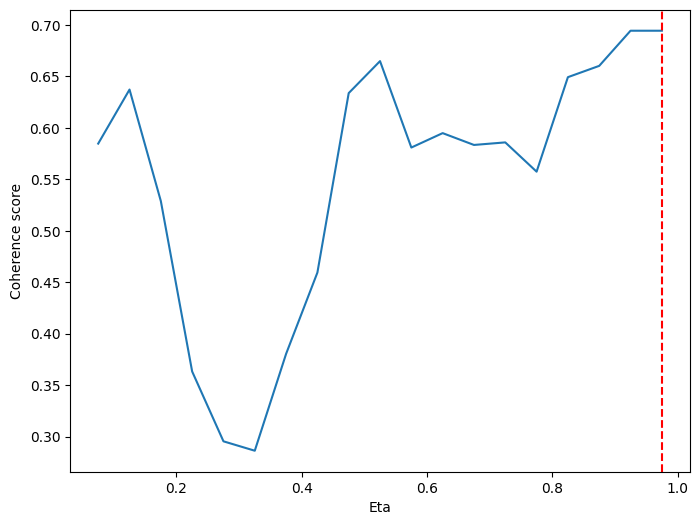

In [28]:
############################### tune eta prior ###############################
# each parameter tuning block takes about 20 minutes to run

# good paramters
base_alpha = 0.15
# reduced number of passes
base_num_passes = 50
base_num_topics = 6
base_lda_seed = 400

# range for eta
limit=0.5; start=0.075; step=0.05;
eta_range = list(np.arange(start,limit, step))
coherence_values_eta = []
model_list_eta = []
for eta in eta_range:
    lda_model, coherence = run_lda(corpus_tfidf, id2word,
                            num_topics=base_num_topics,
                            passes=base_num_passes,
                            alpha=base_alpha,
                            eta=eta,
                            lda_seed=base_lda_seed)
    model_list_eta.append(lda_model)
    coherence_values_eta.append(coherence)


fig, ax = plt.subplots(figsize=(8,6))
plt.plot(eta_range, coherence_values_eta, label = "coherence")
plt.xlabel("Eta", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
eta_best = eta_range[np.where(coherence_values_eta==np.max(coherence_values_eta))[0][0]]
eta_second_best = eta_range[np.argsort(coherence_values_eta)[-2]]
plt.title('Tuning ETA Parameter', fontsize=16);
plt.axvline(eta_best, color='r', linestyle="--", label = "highest");
plt.axvline(eta_second_best, color='b', linestyle="--", label = "second highest");
plt.legend(loc='best', fontsize=14)
plt.show()

if _save_figures_:
    fig.savefig(\
        image_dir+"eta_calibration.png",\
            bbox_inches='tight')

--------------------------------------------------

Coherence Score: 0.6530701766524846
--------------------------------------------------

Perplexity:  -8.668497388591485
--------------------------------------------------

Coherence Score: 0.6943161434190658
--------------------------------------------------

Perplexity:  -8.761391158808763
--------------------------------------------------

Coherence Score: 0.6580819726068152
--------------------------------------------------

Perplexity:  -8.838072243668455
--------------------------------------------------

Coherence Score: 0.5790636659722366
--------------------------------------------------

Perplexity:  -8.901984840912126
--------------------------------------------------

Coherence Score: 0.674318183832862
--------------------------------------------------

Perplexity:  -8.95703907454867
--------------------------------------------------

Coherence Score: 0.6116188651256774
--------------------------------------------------

Pe

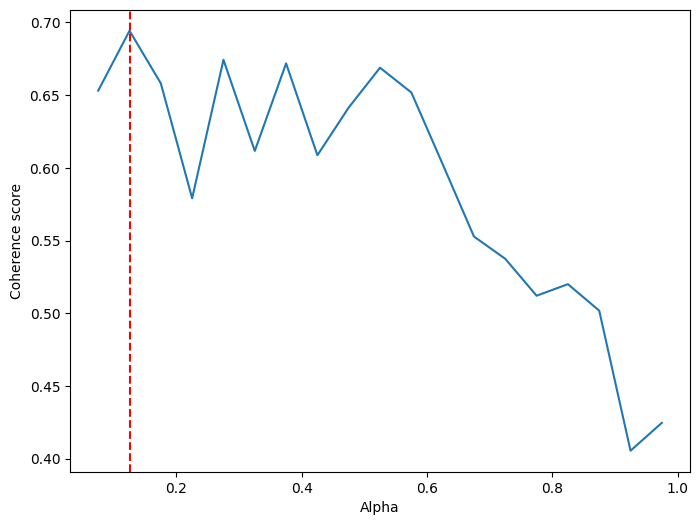

In [35]:
############################### tune alpha prior ###############################
# each parameter tuning block takes about 20 minutes to run

# good parameters to run
base_eta = 0.32
# reduced number of passes
base_num_passes = 50
base_num_topics = 6
base_lda_seed = 400

# range for alpha
limit=0.5; start=0.075; step=0.05;
alpha_range = list(np.arange(start,limit, step))
coherence_values_alpha = []
model_list_alpha = []
for alpha in alpha_range:
    lda_model, coherence = run_lda(corpus_tfidf, id2word,
                            num_topics=base_num_topics,
                            passes=base_num_passes,
                            alpha=alpha,
                            eta=base_eta,
                            lda_seed=base_lda_seed)
    model_list_alpha.append(lda_model)
    coherence_values_alpha.append(coherence)
# plotting
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(alpha_range, coherence_values_alpha, label = "coherence")
plt.xlabel("Alpha", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
alpha_best = alpha_range[np.where(coherence_values_alpha==np.max(coherence_values_alpha))[0][0]]
alpha_second_best = alpha_range[np.argsort(coherence_values_alpha)[-2]]
plt.title('Tuning ALPHA Parameter', fontsize=16);
plt.axvline(alpha_best, color='r', linestyle="--", label = "highest");
plt.axvline(alpha_second_best, color='b', linestyle="--", label = "second highest");
plt.legend(loc='best', fontsize=14)
plt.show()
# save or not
if _save_figures_:
    fig.savefig(\
        image_dir+"alpha_calibration.png",\
            bbox_inches='tight')

--------------------------------------------------

Coherence Score: 0.577542550109634
--------------------------------------------------

Perplexity:  -9.035145044244485
--------------------------------------------------

Coherence Score: 0.6009403973478178
--------------------------------------------------

Perplexity:  -9.09453538954791
--------------------------------------------------

Coherence Score: 0.5461687043124259
--------------------------------------------------

Perplexity:  -9.026731115245354
--------------------------------------------------

Coherence Score: 0.60753071305871
--------------------------------------------------

Perplexity:  -8.981709061872781
--------------------------------------------------

Coherence Score: 0.6465598315347016
--------------------------------------------------

Perplexity:  -9.045869107272011
--------------------------------------------------

Coherence Score: 0.6364472939454219
--------------------------------------------------

Perp

IndexError: list index out of range

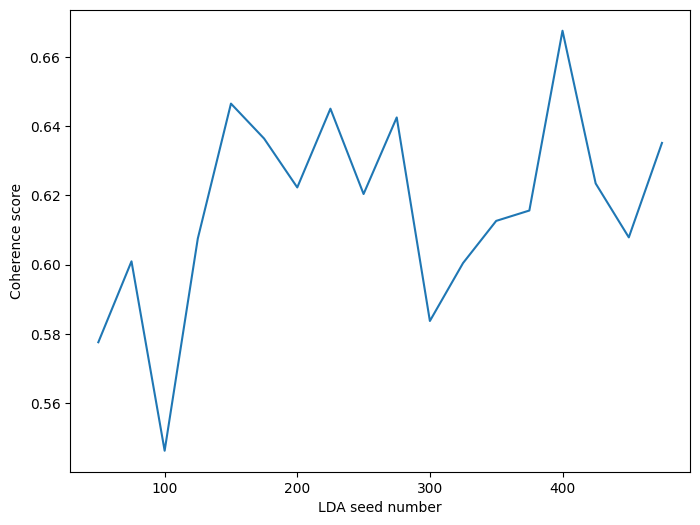

In [233]:
############################### tune LDA seed parameter ###############################
# each parameter tuning block takes about 20 minutes to run

base_eta = 0.15
base_alpha = 0.32
# reduced number of passes
base_num_passes = 50
base_num_topics = 6
# check some random seeds
limit=500; start=50; step=25;
lda_seed_range = list(np.arange(start,limit, step))
coherence_values_seed = []
model_list_seed = []
for lda_seed_var in lda_seed_range:
    lda_model, coherence = run_lda(corpus_tfidf, id2word,
                            num_topics=base_num_topics,
                            passes=base_num_passes,
                            alpha=base_alpha,
                            eta=base_eta,
                            lda_seed=lda_seed_var)
    model_list_seed.append(lda_model)
    coherence_values_seed.append(coherence)
# plotting
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(lda_seed_range, coherence_values_seed, label = "coherence")
plt.xlabel("LDA seed number", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
lda_seed_best = lda_seed_range[np.where(coherence_values_seed==np.max(coherence_values_seed))[0][0]]
lda_seed_second_best = lda_seed_range[np.argsort(coherence_values_seed)[-2]]
plt.title('Tuning LDA SEED Number', fontsize=16);
plt.axvline(lda_seed_best, color='r', linestyle="--", label = "highest");
plt.axvline(lda_seed_second_best, color='b', linestyle="--", label = "second highest");
plt.legend(loc='best', fontsize=14)
plt.show()
# save or not
if _save_figures_:
    fig.savefig(\
        image_dir+"ldaseed_calibration.png",\
            bbox_inches='tight')